![alt text](../images/DIVE%20diagrmas.jpg "Title")


### Library imports

In [1]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(5):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)
    if os.path.basename(module_path).lower() =='frame':
        break
from src.unit import Unit
from src.operators import *
import src.operators
from src.operator_base import op_type_dicts
from src.system import System
import pandas as pd
from src.analye_model import *
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# print(sys.path,module_path)
from utils.display_and_plots import *
data_path = os.path.join(module_path,"data")
model_path = os.path.join(data_path,"model")

### Units.



| Item | Unit | Quantity |
|:--------:|:------------:|:-----------:|
| Memory | 'MB' | 2^20 |
| Compute | 'Tflops' | 10^9 |
| Time | 'msec' | 10^-3 |
| BandWidth | 'GBsec' | 2^30 |
| Freq | 'MHz' | 10^6 |
| Flop | 'MFLOP' | 10^6 |

### DNN Workloads

Our Current Framework supports various different workloads like CNNs, Transformers, Linear Layers.

We break each workload into operators (Individual Operations). Currently we support the following operators:
1. Convolution-2D : <span style="color:blue">Batched Activation</span> Conv <span style="color:Green">Multi Channel Multi kernal Filters</span> 
2. GEMM : <span style="color:blue">Batched Activation</span>  @ <span style="color:Red">Weights</span> 
3. Logit (Multi-Headed Attention) : <span style="color:blue">Batched Activation</span> @ <span style="color:blue">Batched Activation</span>
4. Attend (Multi-Headed Attention) : <span style="color:blue">Batched Activation</span> @ <span style="color:blue">Batched Activation</span>

In [2]:
model = 'custom'
batch_size = 4
unit = Unit()
system = System(unit, mxu_shape=[1,32,32], frequency=1000, offchip_mem_bw=100)
model_df = get_model_df(model = model, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=False, FLAT_enabled = False , 
                         analysis_mode="Frame" )
model_df.filter(items=['Op Type','Dimension','Op Intensity', 'Num ops (MFLOP)', 'Input_a (MB)' ,	'Input_w (MB)',	'Output (MB)',	'Total Data (MB)'])\
        .style.background_gradient(cmap='Blues',axis=0,subset=["Total Data (MB)"])\
        .background_gradient(cmap='Spectral_r',axis=1,subset=['Input_a (MB)','Input_w (MB)','Output (MB)'])\
        .background_gradient(cmap='Oranges',axis=0,subset=["Op Intensity"])


,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,CONV2D,[ 4 64 32 56 56 3 3],175.839196,429.981696,0.382812,0.017578,0.765625,1.166016
1,GEMM,[ 4 768 128 768],219.428571,603.979776,0.375000,0.562500,0.375000,1.312500
2,Logit,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000
3,Attend,[ 4 8 128 128 128],42.666667,134.217728,0.500000,0.500000,0.500000,1.500000


### System

System represents an high-level overview of the compute hardware.


,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy
0,GEMM,[ 1 768 128 768],96.000000,150.994944,0.093750,0.562500,0.093750,0.750000,C,73728.000000,14648.437500,5.033165,73728.000000,18.367347,2.048000,0.073728,1.000000
1,Logit,[ 1 8 128 128 128],42.666667,33.554432,0.125000,0.125000,0.125000,0.375000,C,16384.000000,7324.218750,2.236962,16384.000000,4.081633,2.048000,0.016384,1.000000
2,Attend,[ 1 8 128 128 128],42.666667,33.554432,0.125000,0.125000,0.125000,0.375000,C,16384.000000,7324.218750,2.236962,16384.000000,4.081633,2.048000,0.016384,1.000000
3,GEMM,[ 1 3072 128 768],105.931034,603.979776,0.093750,2.250000,0.375000,2.718750,C,294912.000000,53100.585938,5.553837,294912.000000,73.469388,2.048000,0.294912,1.000000


,Latency (msec),Cycles,MACs (MFLOPS),Total Data (MB),Total Weights (MB),Parameters (MB),On-chip Memory Footprint (MB)
0,0.40,401408.00,822.08,4.22,3.06,2.81,2.72


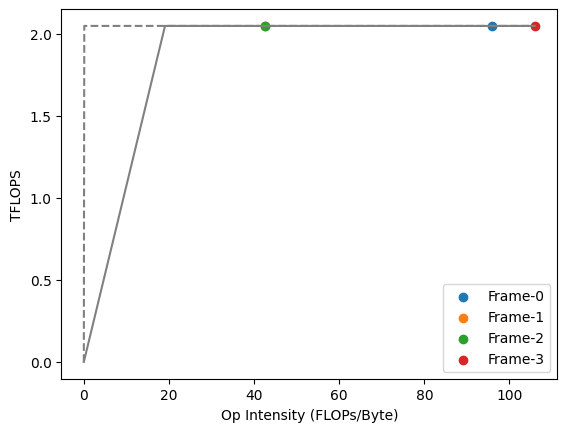

In [3]:

seq_len = 512
model = 'custom_attn_vanilla'
data_path = os.path.join(module_path,"data")
model_path = os.path.join(data_path,"model")
# create_model(seq_len, name=model, data_path=data_path)
# print(model_path)

batch_size = 1
unit = Unit()
system = System(unit, mxu_shape=[1,32,32], frequency=1000, offchip_mem_bw=100)
model_df = get_model_df(model = model, system=system, unit=unit, 
                        batch_size=batch_size, data_path=data_path, sparse=False, FLAT_enabled = False , 
                         analysis_mode="Frame" )
display_df(model_df)

dot_roofline(model_df, system, unit)
get_summary_table(model_df)

In [ ]:
gemm_input = False
log_path = os.getcwd() + "/scale_sim_logs/"

#TODO: Turn off the verbose
s = scalesim(save_disk_space=True, verbose=True,
                config="/Users/abhimanyu/Work/Dive/Scale-sim/configs/scale.cfg",
                topology="./test.csv",
                input_type_gemm=gemm_input
                )
s.run_scale(top_path=log_path)



# total_cycles = 0
layer_wise_cycles = []
for layer_obj in s.runner.single_layer_sim_object_list:
    layer_wise_cycles.append(int(layer_obj.total_cycles))
    
layer_wise_cycles

In [ ]:
operator_list = pd.read_csv("/Users/abhimanyu/Work/Dive/Frame/data/model/custom_attn_vanilla.csv").values.tolist()  
out_operator_list = []
out_batch_list = []
for i,in_op in enumerate(operator_list):
    Batch = 1
    if in_op[-1] == 1:  # Conv
        out_op = ["conv-"+str(i), in_op[2], in_op[3], in_op[4], in_op[5], in_op[1], in_op[0], 1]
    elif in_op[-1] == 3:    # GEMM
        out_op = ["GEMM-"+str(i),in_op[0], in_op[2], 1, in_op[2], 1, in_op[1], 1] 
    elif in_op[-1] == 4:
        Batch =   in_op[0]
        out_op = ["Logit-"+str(i),in_op[1], in_op[3], 1, in_op[3], 1, in_op[2], 1]
    elif in_op[-1] == 5:
        Batch =  in_op[0]
        out_op = ["Attend-"+str(i),in_op[1], in_op[2], 1, in_op[2], 1, in_op[3], 1]
    out_operator_list.append(out_op)
    out_batch_list.append(Batch)

columns = ['Layer Name', 'IFMAP height', 'IFMAP width', 'Filter height', 'Filter width', 'Channels', 'Num filters', 'Stride']
out_df = pd.DataFrame(out_operator_list, columns=columns)
out_df[' '] = pd.Series()
out_df

In [ ]:
out_df
